* Source blog: https://www.analyticsvidhya.com/blog/2021/05/classification-algorithms-in-python-heart-attack-prediction-and-analysis/
* Source data: https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

Understand how to build 4 basic classification algorithm (below) in python from scratch on the same dataset. 
1. Logistic Regression
2. Decision Trees
3. Random Forest
4. K nearest neighbor.

Understanding the dataset. There are 2 csv files - heart.csv & O2saturation.csv. The features (fields) are described below.
1. Age : Age of the patient
2. Sex : Sex of the patient
3. exang: exercise induced angina (1 = yes; 0 = no)
4. ca: number of major vessels (0-3)
5. cp : Chest Pain type chest pain type
6. Value 1: typical angina
7. Value 2: atypical angina
8. Value 3: non-anginal pain
9. Value 4: asymptomatic
10. trtbps : resting blood pressure (in mm Hg)
11. chol : cholestoral in mg/dl fetched via BMI sensor
12. fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
13. rest_ecg : resting electrocardiographic results
14. Value 0: normal
15. Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
16. Value 2: showing probable or definite left ventricular hypertrophy by Estes’ criteria
17. thalach: maximum heart rate achieved
18. output: 0= less chance of heart attack 1= more chance of heart attack

##### Step 1: Load required python libraries

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

##### Step 2: Load the data set

In [41]:
# Load heart.csv dataset into a pandas dataframe (tabular structure)
data1 = pd.read_csv("heart.csv")
data1 = pd.DataFrame(data1)

# See the data frame information
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [42]:
# See how many rows, columns in dataframe
data1.shape

(303, 14)

In [43]:
# See the data frame head (ie. first 5 rows)
data1.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


##### Step 3: Data Cleaning / Pre processing

Before providing data to a model, it is essential to clean the data and treat the nulls, outliers, duplicate data records.

In [44]:
# Check duplicate rows
duplicate_rows = data1[data1.duplicated()]
print("Number of duplicate rows :: ", duplicate_rows.shape)

Number of duplicate rows ::  (1, 14)


In [46]:
# Remove the duplicate record
data1 = data1.drop_duplicates()
duplicate_rows = data1[data1.duplicated()]
print("Number of duplicate rows :: ", duplicate_rows.shape)

Number of duplicate rows ::  (0, 14)


In [47]:
# Check to confirm that there are no null values in any feature
print("Null values :: ")
print(data1.isnull().sum())

Null values :: 
age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64


<AxesSubplot:xlabel='age'>

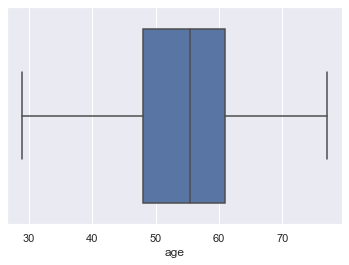

In [48]:
# For eg do a boxplot for say 'age' as below. No Outliers observed in 'age'.
sns.boxplot(x=data1['age'])

When we run individually each feature box plot we notice the below:
* No outliers in age, sex & cp 
* Some outliers are observed in 'trtbps'. They will be removed later
* Some outliers are observed in 'chol', 'fbs','restcg', 'thalachh'. They will be removed later
* Outliers are present in 'exng', OldPeak','slp',caa','thall'

<AxesSubplot:xlabel='output', ylabel='age'>

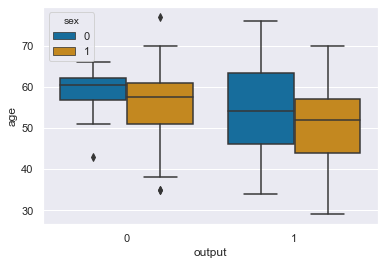

In [49]:
# Note" We can plot multiple boxplots into 1 grouped box plot as below. This is just for illustration.
sns.boxplot(y='age', x='output', 
                 data=data1, 
                 palette="colorblind",
                 hue='sex')

Now to remove outliers we have two methods:
A. Inter-Quartile Range
B. Z-score

##### A. Inter-Quartile Range
This is calcluated as IQR = Q3-Q1. That is Q1 is the 25% Quantile & Q3 is the 75% Quantile. So Q3-Q1 is the area within the box & outliers are calcluated as 1.5 times this value from Q1 & Q3. This means the data points higher than the upper limit and lower than the lower limit are considered outliers. The limits are calcluated by using the below formula:
* upper limit = Q3 + 1.5 * IQR
* lower limit = Q1 – 1.5 * IQR

In [50]:
#Find the InterQuartile Range
Q1 = data1.quantile(0.25)
Q3 = data1.quantile(0.75)
IQR = Q3-Q1
print('*********** InterQuartile Range ***********')
print(IQR)

# Remove the outliers using IQR and store in new dataframe data2
data2 = data1[~((data1<(Q1-1.5*IQR))|(data1>(Q3+1.5*IQR))).any(axis=1)]
data2.shape
# You will notice that the dataframe has been reduced from original 303 to now 228 rows

*********** InterQuartile Range ***********
age         13.00
sex          1.00
cp           2.00
trtbps      20.00
chol        63.75
fbs          0.00
restecg      1.00
thalachh    32.75
exng         1.00
oldpeak      1.60
slp          1.00
caa          1.00
thall        1.00
output       1.00
dtype: float64


(228, 14)

##### B. Z – Score
If a Z-score is greater than 3, it implies that the data point differs from the other data points and hence is treated as an outlier. z score is an inherent function of stats library built into python.

In [51]:
#Removing outliers using Z-score & storing in new dataframe data3
z = np.abs(stats.zscore(data1))
data3 = data1[(z<3).all(axis=1)]
data3.shape
# You will notice that the dataframe has been reduced from original 303 to now 287 rows ie. 59 more rows than using IQR.

(287, 14)

##### Correlation
After removing outliers from data, we will find the correlation between all the features. Two types of correlation will be used here.
* A. Pearson Correlation
* B. Spearman Correlation (but we will not plot Spearman to save time)

Text(0.5, 1.0, 'Pearson Correlation')

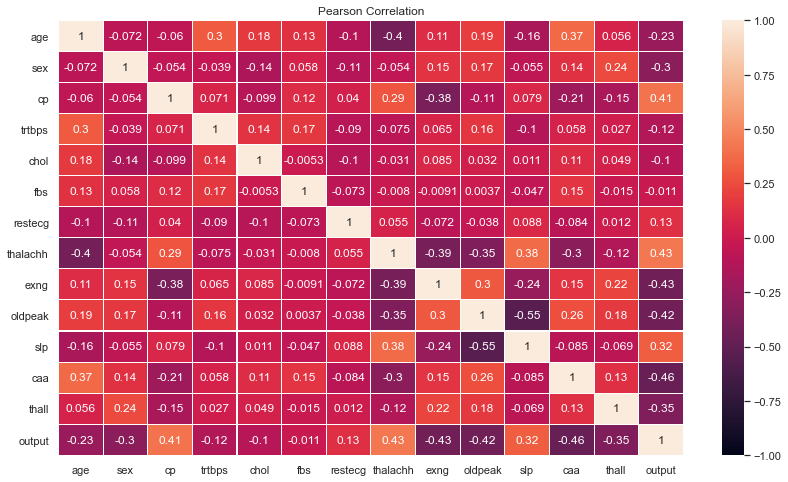

In [52]:
#Finding the correlation between variables
pearsonCorr = data3.corr(method='pearson')
spearmanCorr = data3.corr(method='spearman')

# Plot Pearson Correlation matrix
fig = plt.subplots(figsize=(14,8))
sns.heatmap(pearsonCorr, vmin=-1,vmax=1, annot=True, linewidth=0.1)
plt.title("Pearson Correlation")

Text(0.5, 1.0, 'Pearson Correlation')

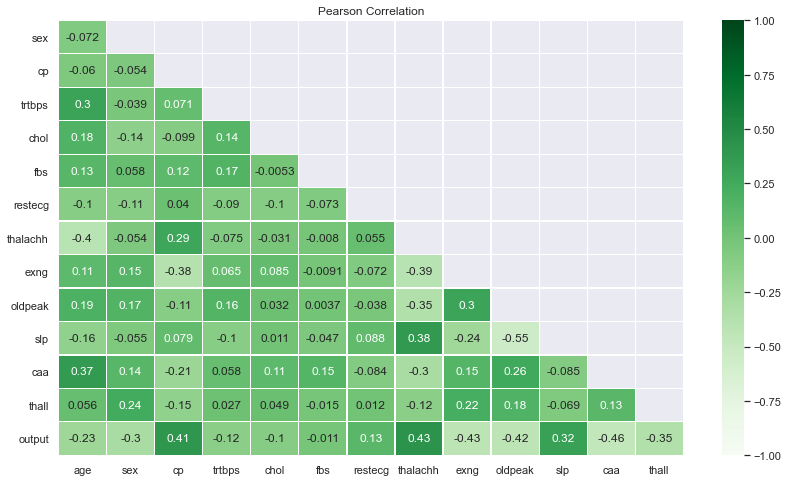

In [53]:
# Since the resultant matrix is a mirror image, we will mask the upper half (above the diagonal).
# Also make the colors lighter using color map (cmap) Greens
#Pearson corr masking
#Generating mask for upper triangle
maskP = np.triu(np.ones_like(pearsonCorr,dtype=bool))
#Adjust mask and correlation
maskP = maskP[1:,:-1]
pCorr = pearsonCorr.iloc[1:,:-1].copy()
#Setting up a diverging palette
#cmap = sns.diverging_palette(0, 200, 150, 50, as_cmap=True)
fig = plt.subplots(figsize=(14,8))
sns.heatmap(pCorr, vmin=-1,vmax=1, cmap= 'Greens', annot=True, linewidth=0.3, mask=maskP)
plt.title("Pearson Correlation")

From the heat map it is clear that the features fbps, chol and trtbps have the lowest correlation with output. 

##### Step 4: Split dataset into training data & test data.
Before implementing any classification algorithm, we will create the supervised learning using sklearn train_test_split method.

1. drop the target 'y' variable from the dataset before splitting the dataset 
2. divide our dataset into training data and test data. Here we will keep 70% of the data for training and the remaining 30% for testing.

In [63]:
x = data3.drop("output", axis=1)
y = data3["output"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

#### Step 5: Finally Classification!!

We will implement four classification algorithms,
1. Logistic Regression Classifier
2. Decision Trees Classifier
3. Random Forest Classifier
4. K Nearest Neighbours Classifier

##### 1. Logistic Regression Classifier

In [64]:
names = ['Age', 'Sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall']
#   ****************Logistic Regression*****************
logReg = LogisticRegression(random_state=0, solver='liblinear')
logReg.fit(x_train, y_train)
#Check accuracy of Logistic Regression
y_pred_logReg = logReg.predict(x_test)

#Model Accuracy
acy1=metrics.accuracy_score(y_test,y_pred_logReg1)
print("Accuracy of logistic regression classifier :: ",acy1)

#Removing the features with low correlation and checking effect on accuracy of model
x_train1 = x_train.drop("fbs",axis=1)
x_train1 = x_train1.drop("trtbps", axis=1)
x_train1 = x_train1.drop("chol", axis=1)
x_train1 = x_train1.drop("restecg", axis=1)
x_test1 = x_test.drop("fbs", axis=1)
x_test1 = x_test1.drop("trtbps", axis=1)
x_test1 = x_test1.drop("chol", axis=1)
x_test1 = x_test1.drop("restecg", axis=1)
logReg1 = LogisticRegression(random_state=0, solver='liblinear').fit(x_train1,y_train)
y_pred_logReg1 = logReg1.predict(x_test1)

# Measure the model accuracy on test data using the sklearn metrics method as below.
acy2=metrics.accuracy_score(y_test,y_pred_logReg1)
print("Accuracy of logistic regression classifier after removing features:: ",acy2)

Accuracy of logistic regression classifier ::  0.4942528735632184
Accuracy of logistic regression classifier after removing features::  0.8850574712643678


Significant improvement in accuracy of nearly 38% after removing features with low correlation!!!!

##### 2. Decision Tree Classifier

In [65]:
# ***********************Decision Tree Classification***********************
decTree = DecisionTreeClassifier(max_depth=6, random_state=0)
decTree.fit(x_train,y_train)
y_pred_decTree = decTree.predict(x_test)
print("Accuracy of Decision Trees :: " , metrics.accuracy_score(y_test,y_pred_decTree))

#Remove features which have low correlation with output (fbs, trtbps, chol)
x_train_dt = x_train.drop("fbs",axis=1)
x_train_dt = x_train_dt.drop("trtbps", axis=1)
x_train_dt = x_train_dt.drop("chol", axis=1)
x_train_dt = x_train_dt.drop("age", axis=1)
x_train_dt = x_train_dt.drop("sex", axis=1)
x_test_dt = x_test.drop("fbs", axis=1)
x_test_dt = x_test_dt.drop("trtbps", axis=1)
x_test_dt = x_test_dt.drop("chol", axis=1)
x_test_dt = x_test_dt.drop("age", axis=1)
x_test_dt = x_test_dt.drop("sex", axis=1)
decTree1 = DecisionTreeClassifier(max_depth=6, random_state=0)
decTree1.fit(x_train_dt, y_train)
y_pred_dt1 = decTree1.predict(x_test_dt)
print("Accuracy of decision Tree after removing features:: ", metrics.accuracy_score(y_test,y_pred_dt1))

Accuracy of Decision Trees ::  0.7126436781609196
Accuracy of decision Tree after removing features::  0.7241379310344828


Improvement in accuracy of just 1% after removing features with low correlation. But looks like logistic regression is slightly more accurate than decision tree!!

##### 3. Random Forest Classifier

In [66]:
# Using Random forest classifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
print("Accuracy of Random Forest Classifier :: ", metrics.accuracy_score(y_test, y_pred_rf))

#Find the score of each feature in model and drop the features with low scores
f_imp = rf.feature_importances_
for i,v in enumerate(f_imp):
    print('Feature: %s, Score: %.5f' % (names[i],v))

Accuracy of Random Forest Classifier ::  0.8275862068965517
Feature: Age, Score: 0.09083
Feature: Sex, Score: 0.03222
Feature: cp, Score: 0.10099
Feature: trtbps, Score: 0.08010
Feature: chol, Score: 0.08566
Feature: fbs, Score: 0.00931
Feature: restecg, Score: 0.01904
Feature: thalachh, Score: 0.11244
Feature: exng, Score: 0.08052
Feature: oldpeak, Score: 0.13411
Feature: slp, Score: 0.04852
Feature: caa, Score: 0.11953
Feature: thall, Score: 0.08673


IF you run the logistic regression multiple times, the accuracy varies quite a lot!! Hence Random Forest gives similar accuracy prediction as logistic regression!! And from above it is clear that cp, thalachh & thall are the top 3 incluencing features on target variable.

##### 4. k Nearest Neighbours

In [67]:
knc =  KNeighborsClassifier()
knc.fit(x_train,y_train)
y_pred_knc = knc.predict(x_test)
print("Accuracy of K-Neighbours classifier :: ", metrics.accuracy_score(y_test,y_pred_knc))

Accuracy of K-Neighbours classifier ::  0.7011494252873564


In [68]:
#Models and their accuracy
print("*****************Models and their accuracy*****************")
print("Logistic Regression Classifier :: ", metrics.accuracy_score(y_test,y_pred_logReg1))
print("Decision Tree :: ", metrics.accuracy_score(y_test,y_pred_dt1))
print("Random Forest Classifier :: ", metrics.accuracy_score(y_test, y_pred_rf))
print("K Neighbours Classifier :: ", metrics.accuracy_score(y_test,y_pred_knc))

*****************Models and their accuracy*****************
Logistic Regression Classifier ::  0.8850574712643678
Decision Tree ::  0.7241379310344828
Random Forest Classifier ::  0.8275862068965517
K Neighbours Classifier ::  0.7011494252873564


After implementing four classification models and comparing their accuracy, we can conclude that for this dataset Logistic Regression Classifier or Random Forest algorithm can be used to create model for this dataset.